In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd

In [3]:
from birds_utils import DataGenerator, DataGeneratorV2, get_class_audio_files_npy

# dataset_folder_train = './dataset/train/'
# dataset_folder_val = './dataset/val/'
# dgen_train = DataGenerator(dataset_folder_train, batch_size=128)
# dgen_val = DataGenerator(dataset_folder_val, batch_size=128)

train_files = np.load('train_files.npy')
val_files = np.load('val_files.npy')
train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')


# TARGET_FOLDER = './dataset/npy_22050/'

# class_audiofiles, train_files, val_files, train_labels, val_labels = get_class_audio_files_npy(TARGET_FOLDER)

In [4]:
# np.save('train_files.npy', train_files)
# np.save('val_files.npy', val_files)
# np.save('train_labels.npy', train_labels)
# np.save('val_labels.npy', val_labels)

In [15]:
min_std = 0.5
N = 20
dgen_train = DataGeneratorV2(list(train_files)*N, list(train_labels)*N, min_std=min_std, batch_size=128)
dgen_val = DataGeneratorV2(list(val_files)*N, list(val_labels)*N, min_std=min_std, batch_size=128)

{'aldfly': 0, 'amecro': 1, 'amegfi': 2}
{'aldfly': 0, 'amecro': 1, 'amegfi': 2}


In [11]:
# dgen_val.indexes

In [12]:
# full = np.load(train_files[0])
# plt.figure(figsize=(30,4))
# plt.plot(full)
# x, fr, to = dgen_train.sample_audio_clip(train_files[0])
# trunc = np.zeros(len(full))
# trunc[fr: to] = x
# plt.plot(trunc)
# plt.show()
# plt.plot(x)

In [13]:
len(dgen_val)/(len(dgen_train) + len(dgen_val))

0.1702127659574468

In [14]:
%%time
for x, c in dgen_train:
    print(x.shape, c.shape)
    
# for x, c in dgen_val:
#     print(x.shape, c.shape)

(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)


KeyboardInterrupt: 

In [8]:
# c

In [9]:
# for i in range(32):
#     print(x[i,:,0].std())

In [12]:
# plt.plot(x[0,:,0])
# ipd.Audio(x[0,:,0], rate=22050)
# x[0,:,0].std()

In [14]:
# len(dgen_train), len(dgen_val)

In [14]:
# del X, y

In [16]:
def get_fourier_weights(window_size):
    frec = np.linspace(-window_size//2, window_size//2-1, window_size)
    time = np.linspace(0, window_size-1, window_size)
    hanning_window = np.hanning(window_size)

    filters_cos = []
    filters_sin = []
    for i in range(window_size//2):
        filters_cos.append(np.cos(2*np.pi*frec[i]*time/window_size))
        filters_sin.append(np.sin(2*np.pi*frec[i]*time/window_size))
    filters_cos = np.array(filters_cos)[::-1]*hanning_window
    filters_sin = np.array(filters_sin)[::-1]*hanning_window
    return filters_cos, filters_sin

def set_cnn_weights(model, filters_cos, filters_sin, cos_layer='cos', sin_layer='sin'):
    weights_cos = model.get_layer(cos_layer).get_weights()
    weights_sin = model.get_layer(sin_layer).get_weights()
    weights_cos[0] = np.array(filters_cos).T.reshape(kernel_size, 1, filters)
    weights_sin[0] = np.array(filters_sin).T.reshape(kernel_size, 1, filters)
    model.get_layer(cos_layer).set_weights(weights_cos)
    model.get_layer(sin_layer).set_weights(weights_sin)

In [17]:
from tensorflow.keras.layers import Dense, Conv1D, Input, MaxPool1D, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [18]:
#model = Sequential()
window_size = 1024
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2
inp = Input(shape=(None,1))
cos_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'cos')(inp)
sin_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'sin')(inp)
fourier_out = K.log(K.square(cos_out) + K.square(sin_out))
# fourier_out = Activation('relu')(cos_out) + Activation('relu')(sin_out)
gap_out = GlobalAveragePooling1D()(fourier_out)
out = Dense(3, activation='softmax')(gap_out)

#  model = Model(inp, [fourier_out, out])
model = Model(inp, out)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
cos (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
sin (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square (TensorFlowO [(None, None, 512)]  0           cos[0][0]                        
______________________________________________________________________________________________

In [19]:
filters_cos, filters_sin = get_fourier_weights(window_size)
set_cnn_weights(model, filters_cos, filters_sin)

In [20]:
# model.get_layer('cos').trainable = False
# model.get_layer('sin').trainable = False

In [25]:
cbs = [
    callbacks.ModelCheckpoint('weights_1024.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True),
    # callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-5)
] 
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
model_fourier = Model(inp, [fourier_out, out])

In [54]:
fourier_out, out = model_fourier.predict_generator(dgen_val)

In [55]:
fourier_out.shape

(1024, 431, 512)

In [57]:
2*5*22050/512

430.6640625

In [24]:

history = model.fit(dgen_train, epochs=200, validation_data=dgen_val, callbacks=cbs, use_multiprocessing=False, workers=8)

Epoch 1/200
39/39 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9702
Epoch 00001: val_accuracy did not improve from 0.74023
39/39 [==============================] - 15s 391ms/step - loss: 0.1122 - accuracy: 0.9702 - val_loss: 1.2113 - val_accuracy: 0.6514
Epoch 2/200
39/39 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9647
Epoch 00002: val_accuracy did not improve from 0.74023
39/39 [==============================] - 15s 390ms/step - loss: 0.1211 - accuracy: 0.9647 - val_loss: 1.2897 - val_accuracy: 0.6826
Epoch 3/200
39/39 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9681
Epoch 00003: val_accuracy did not improve from 0.74023
39/39 [==============================] - 15s 389ms/step - loss: 0.1155 - accuracy: 0.9681 - val_loss: 1.1697 - val_accuracy: 0.7031
Epoch 4/200
39/39 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9710
Epoch 00004: val_accuracy did not improve from 0.74023
39/3

KeyboardInterrupt: 

In [30]:
# time = np.linspace(0, window_size-1, window_size)
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_cos[i])
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_sin[i])

In [31]:
# filters_cos, filters_sin = get_fourier_weights(window_size)
# set_cnn_weights(model, filters_cos, filters_sin)

In [33]:
model.evaluate(dgen_val)

8/8 [==============================] - 3s 349ms/step - loss: 1.5121 - accuracy: 0.7402


[1.5120853185653687, 0.740234375]

In [36]:
model.load_weights('weights_1024.hdf5')
model.evaluate(dgen_val)

8/8 [==============================] - 3s 340ms/step - loss: 1.6343 - accuracy: 0.7666


[1.6343029737472534, 0.7666015625]

In [37]:
# 0.9569892287254333 window size 512

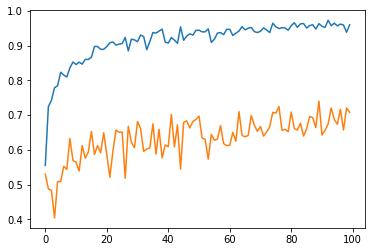

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [39]:
weights_cos = model.get_layer('cos').get_weights()[0].T.reshape(filters_cos.shape)
weights_sin = model.get_layer('sin').get_weights()[0].T.reshape(filters_sin.shape)

In [40]:
most_diff_indexes = np.argsort((weights_cos - filters_cos).var(axis=1))[::-1]

In [41]:
most_diff_indexes[:20]

array([ 65,   8,  68,  77,  23, 140,   4,   7, 169, 159,  27, 170, 108,
       143, 166,  60,  71,  10,  78,  43])

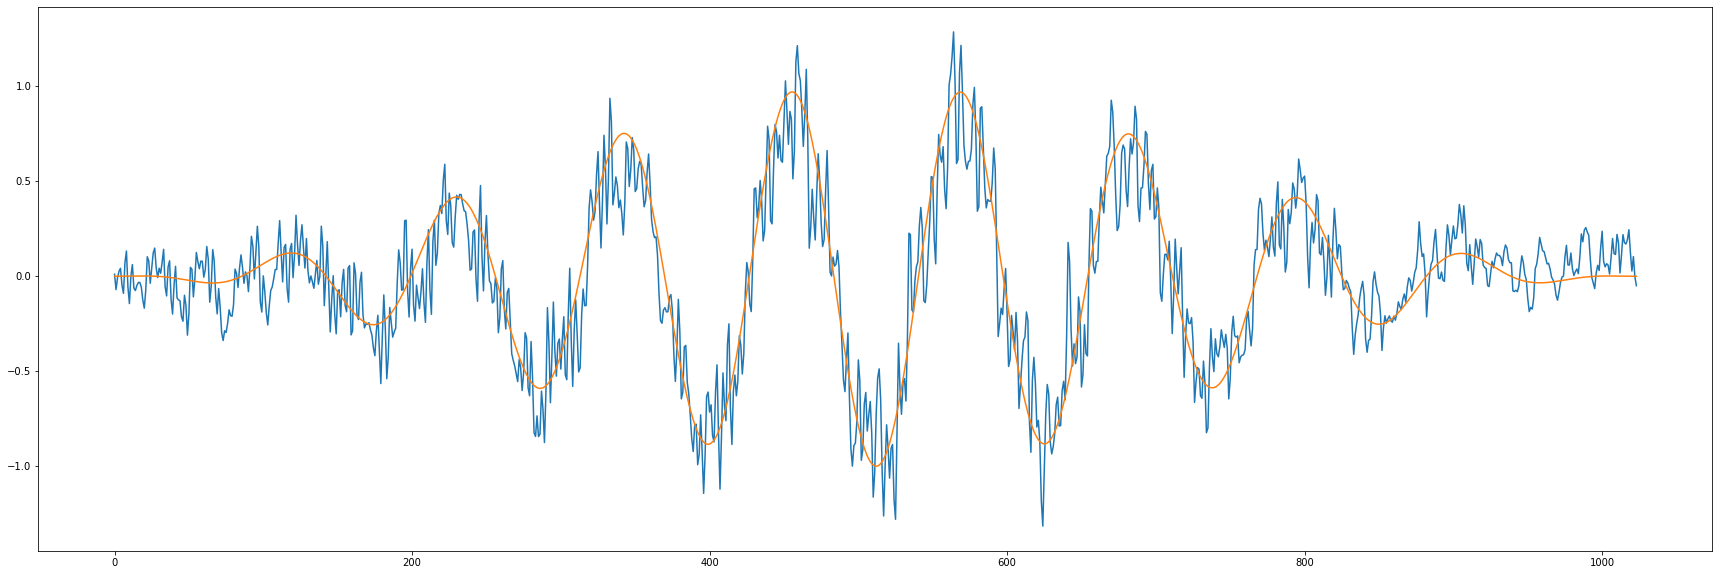

In [43]:
idx = 8
plt.figure(figsize=(30,10))
plt.plot(weights_cos[idx])
plt.plot(filters_cos[idx])

In [48]:
# x, sr, duration = get_train_clip(train[train['ebird_code']=='ameavo'].iloc[0])
# print(duration)